Data Preprocessing

cuda
Processing train data...
Finished processing 8691 images from train set.
Processing valid data...
Finished processing 2483 images from valid set.
Processing test data...
Finished processing 1242 images from test set.
Displaying an image from the train set:


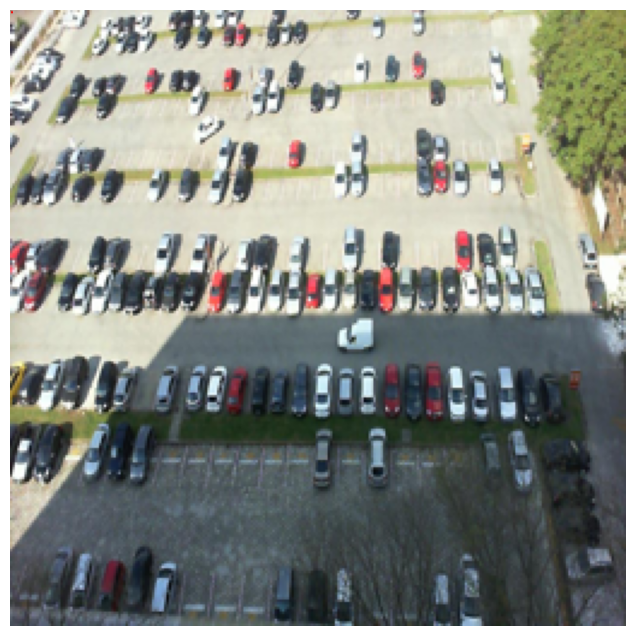

Displaying an image from the valid set:


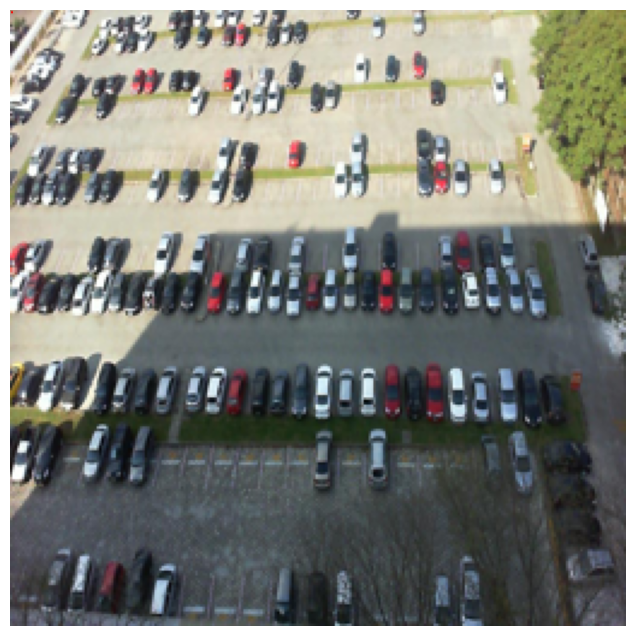

Displaying an image from the test set:


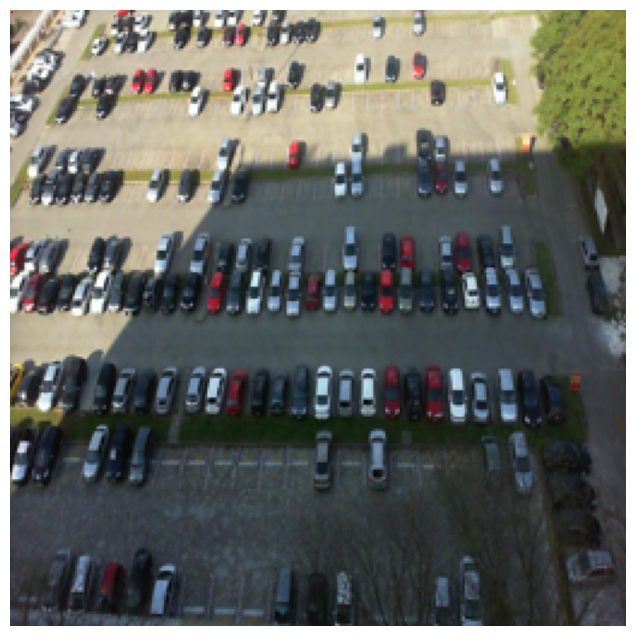

In [34]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def parse_annotation(labels_path):
    objects = []
    with open(labels_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            coordinates = list(map(float, parts[1:]))  # Convert all to float
            xs = coordinates[0::2]  # Extract all x coordinates
            ys = coordinates[1::2]  # Extract all y coordinates
            xmin, xmax = min(xs), max(xs)
            ymin, ymax = min(ys), max(ys)
            objects.append((class_id, xmin, ymin, xmax, ymax))
    return objects

def resize_image(image, new_width, new_height, boxes):
    width, height = image.size
    resize_ratio_w = new_width / width
    resize_ratio_h = new_height / height
    image = image.resize((new_width, new_height))
    
    resized_boxes = []
    for box in boxes:
        class_id, x1, y1, x2, y2 = box
        resized_boxes.append((
            class_id,
            x1 * resize_ratio_w,
            y1 * resize_ratio_h,
            x2 * resize_ratio_w,
            y2 * resize_ratio_h
        ))
    return image, resized_boxes

def preprocess_image(image_path, annotation_path, target_size=(256, 256)):
    image = Image.open(image_path)
    boxes = parse_annotation(annotation_path)
    
    image, boxes = resize_image(image, target_size[0], target_size[1], boxes)
    image_np = np.array(image) / 255.0  # Normalize pixel values
    
    return image_np, boxes

def process_directory(data_dir, annotation_dir, target_size=(256, 256)):
    processed_data = []
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            processed_image, processed_boxes = preprocess_image(image_path, annotation_path, target_size)
            processed_data.append((processed_image, processed_boxes))
    return processed_data

# Example usage
dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (256, 256)  # Change as required by your model

all_data = {}
for part in partitions:
    print(f"Processing {part} data...")
    images_dir = os.path.join(dataset_base, part, 'images')
    annotations_dir = os.path.join(dataset_base, part, 'labels')  # Adjust if different
    all_data[part] = process_directory(images_dir, annotations_dir, target_size)
    print(f"Finished processing {len(all_data[part])} images from {part} set.")

# Define a function to display an image with bounding boxes
def show_image_with_boxes(image, boxes):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for class_id, xmin, ymin, xmax, ymax in boxes:
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='r', facecolor='none'))
    plt.axis('off')
    plt.show()

# Display an image from each set
for part in partitions:
    print(f"Displaying an image from the {part} set:")
    image_np, boxes = all_data[part][0]  # Get the first image and its boxes from the set
    image = Image.fromarray((image_np * 255).astype(np.uint8))
    show_image_with_boxes(image, boxes)



Semantics CNN

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the CNN architecture for segmentation
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid for binary segmentation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def preprocess_image(image_path, annotation_path, target_size=(256, 256)):
    image = Image.open(image_path).resize(target_size, Image.ANTIALIAS)
    mask = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)  # Initialize the mask with zeros

    if os.path.exists(annotation_path) and os.path.getsize(annotation_path) > 0:
        with open(annotation_path, 'r') as file:
            lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:  # Assuming the first item is not part of the coordinates
                try:
                    x_min, y_min, x_max, y_max = map(int, map(float, parts[1:5]))  # Only take the first four values after the first item
                    mask[y_min:y_max, x_min:x_max] = 1  # Set pixels within bounding box to 1
                except ValueError as e:
                    print(f"Error processing line '{line.strip()}': {e}")
                    continue

    mask = Image.fromarray(mask)  # Convert mask to PIL image for possible further transformations
    return np.array(image), np.array(mask)

class PKLotDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, mask = self.data[idx]
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)  # Transform the mask just like the image
        return image, mask

def process_directory(data_dir, annotation_dir, target_size=(256, 256)):
    processed_data = []
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            processed_image, processed_mask = preprocess_image(image_path, annotation_path, target_size)
            processed_data.append((processed_image, processed_mask))
    return processed_data

def process_dataset(dataset_base, target_size=(256, 256)):
    all_data = {}
    for part in ['train', 'valid', 'test']:
        images_dir = os.path.join(dataset_base, part, 'images')
        annotations_dir = os.path.join(dataset_base, part, 'labels')
        all_data[part] = process_directory(images_dir, annotations_dir, target_size)
        print(f"Finished processing {len(all_data[part])} images from {part} set.")
    return all_data

dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (256, 256)

all_data = process_dataset(dataset_base, target_size)

# Create datasets and dataloaders for train, validation, and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = PKLotDataset(all_data['train'], transform=transform)
valid_dataset = PKLotDataset(all_data['valid'], transform=transform)
test_dataset = PKLotDataset(all_data['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationModel().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Specify the number of epochs
    model.train()
    for images, masks in train_loader:
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device).float()  # Ensure masks are float
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()  # Ensure correct loss calculation without `unsqueeze`

    print(f'Epoch [{epoch+1}/10], Train Loss: {loss.item():.4f}, Valid Loss: {val_loss/len(valid_loader):.4f}')


C:\Users\SirM\AppData\Local\Temp\ipykernel_6584\543987666.py:40: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = Image.open(image_path).resize(target_size, Image.ANTIALIAS)


Finished processing 8691 images from train set.
Finished processing 2483 images from valid set.
Finished processing 1242 images from test set.


In [ ]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Set the base directory where the train, valid, and test folders are located
base_dir = r'C:/Users/SirM/Downloads/PKLot.v1-raw.voc'

# Define the desired image shape
desired_shape = (256, 256)  # Example size, adjust as needed

# Function to parse XML annotation and create a binary mask
def parse_annotation(xml_path, img_shape):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Initialize a mask with zeros
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    
    # Extract bounding boxes and set corresponding mask regions to 1
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        mask[ymin:ymax, xmin:xmax] = 1  # Mark occupied spaces as 1
    
    return mask

# Function to load images and corresponding annotations
def load_images_and_masks(data_dir, desired_shape):
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    images = []
    masks = []
    
    for image_file in image_files:
        # Load image
        img_path = os.path.join(data_dir, image_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, desired_shape[::-1])  # OpenCV expects width x height
        img = img / 255.0  # Normalize image pixels to [0, 1]
        
        # Load corresponding annotation
        xml_file = image_file.replace('.jpg', '.xml')
        xml_path = os.path.join(data_dir, xml_file)
        mask = parse_annotation(xml_path, img.shape)
        mask = cv2.resize(mask, desired_shape[::-1])  # Resize mask like the image
        
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

# Preprocess each dataset
train_images, train_masks = load_images_and_masks(os.path.join(base_dir, 'train'), desired_shape)
valid_images, valid_masks = load_images_and_masks(os.path.join(base_dir, 'valid'), desired_shape)
test_images, test_masks = load_images_and_masks(os.path.join(base_dir, 'test'), desired_shape)

# At this point, you have numpy arrays of images and masks for training, validation, and testing
